In [2]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylorentz import Momentum4

In [3]:
def gen_Files():
    
    #FORMAT:
    # mcWeight, SumWeights, sf_Pileup, sf_Photon, sf_Btag, sf_Trigger, 
    # Gam1(pt,eta,phi,E, trigM, Tight, ptCone, etaCone),Gam2(...), lep_n, trigP, jet_n, jet1(...,Btag),...

    #Input files to read, scale factor files to write, and data files to write
    in_files = ['ggHout.csv', 'dataAout.csv', 'dataBout.csv', 'dataCout.csv','dataDout.csv']
    sf_files = ['ggH_sf.csv', 'dataA_sf.csv', 'dataB_sf.csv', 'dataC_sf.csv', 'dataD_sf.csv']
    data_files = ['ggH.csv','dataA.csv','dataB.csv','dataC.csv','dataD.csv']
    
    #Due to ragged CSV files, must find the file with the longest row
    #Then column names can be generated and passed to pandas
    #when opening the file
    max_lens = []
    for i in range(len(in_files)):

        max_row = len(max(open('./../CSVfiles/{}'.format(in_files[i]), 'r'),key=len).split(',')) -1
        max_lens.append(max_row)

    biggest_row = max(max_lens) #This is 100  
    col_names = ['mcweight', 'sumweights', 'sf_pileup', 'sf_photon', 'sf_btag', 'sf_trigger', 'g1_pt','g1_eta',
                 'g1_phi','g1_E','g1_trigm','g1_tight','g1_ptcone','g1_etacone','g2_pt','g2_eta',
                 'g2_phi','g2_E','g2_trigm','g2_tight','g2_ptcone','g2_etacone', 'lep_n', 'trigP', 'jet_n',
                 'j1_pt','j1_eta','j1_phi','j1_E','j1_MV2C10','j2_pt','j2_eta','j2_phi','j2_E','j2_MV2C10',
                 'j3_pt','j3_eta','j3_phi','j3_E','j3_MV2C10','j4_pt','j4_eta','j4_phi','j4_E','j4_MV2C10',
                 'j5_pt','j5_eta','j5_phi','j5_E','j5_MV2C10','j6_pt','j6_eta','j6_phi','j6_E','j6_MV2C10',
                 'j7_pt','j7_eta','j7_phi','j7_E','j7_MV2C10','j8_pt','j8_eta','j8_phi','j8_E','j8_MV2C10',
                 'j9_pt','j9_eta','j9_phi','j9_E','j9_MV2C10','j10_pt','j10_eta','j10_phi','j10_E','j10_MV2C10',
                 'j11_pt','j11_eta','j11_phi','j11_E','j11_MV2C10','j12_pt','j12_eta','j12_phi','j12_E','j12_MV2C10',
                 'j13_pt','j13_eta','j13_phi','j13_E','j13_MV2C10','j14_pt','j14_eta','j14_phi','j14_E','j14_MV2C10',
                 'j15_pt','j15_eta','j15_phi','j15_E','j15_MV2C10']
    
    #Parse through each file, process it, then write to the new files
    for i in range(len(in_files)):
        
        #As we write in chunks, we need to make the column names only appear 
        #for the first chunk
        header_counter = 0

        #Read CSV in chunks 
        for df in pd.read_csv('./../CSVfiles/{}'.format(in_files[i]), names = col_names, chunksize = 10000):

            #Replace NaN values with integer
            df.fillna(-10**6, inplace = True)

            #Filter out entries with > 0 leptons, get rid of the column
            indexes = df.loc[df['lep_n'] > 0].index
            df.drop(indexes,inplace = True)
            df.drop(['lep_n'], inplace = True)

            #Make units into GeV
            df['g1_pt'] = df['g1_pt']/1000
            df['g2_pt'] = df['g2_pt']/1000
            df['g1_E'] = df['g1_E']/1000
            df['g2_E'] = df['g2_E']/1000

            #Generate a label column for signal/background split
            #Background conditions are: at least 1 photon is not tight, or at least 
            #least one photon has ptCone/pt > 0.05, or at least one photon
            #has etaCone/eta > 0.065

            pt1Ratio = df['g1_ptcone']/df['g1_pt']
            pt2Ratio = df['g2_ptcone']/df['g2_pt']
            eta1Ratio = df['g1_etacone']/df['g1_eta']
            eta2Ratio = df['g2_etacone']/df['g2_eta']

            bkg_inds = df[((df['g1_tight'] == 0) | (df['g2_tight'] == 0)) | ((pt1Ratio > 0.05) | (pt2Ratio > 0.05))
                    | ((eta1Ratio > 0.065) | (eta2Ratio > 0.065))].index
            truths = []
            list_1 = set(df.index)
            list_2 = set(bkg_inds)

            list_3 = set(list_1 | list_2)
            for elem in sorted(list_3):
                if elem in list_1:
                    if elem in list_2:
                        truths.append(0) 
                    else:
                        truths.append(1)

            #Use PyLorentz to calculate the quantities associated with the
            #parent of the two photons
            inv_masses, trans_momenta, energies, etas, phis = parent_Quantities(df[['g1_pt', 'g1_eta', 'g1_phi', 'g1_E',
                                                                                    'g2_pt', 'g2_eta', 'g2_phi', 'g2_E']].values)

            #Calculate photon separation angle (eq: sqrt(eta1-eta2)^2+(phi1-phi2)^2))
            del_r = np.zeros((df.shape[0]))
            
            for t in range(df.shape[0]):
                del_r[t] = np.sqrt((df.iloc[t, 7]-df.iloc[t, 15])**2 + (df.iloc[t, 8]-df.iloc[t, 16])**2)
            
            #Add the new columns to the dataframe
            df.insert(loc=0, column='photon_sep', value=del_r)
            df.insert(loc=0, column='p_E', value=energies)
            df.insert(loc=0, column='p_phi', value=phis)
            df.insert(loc=0, column='p_eta', value=etas)
            df.insert(loc=0, column='p_pt', value=trans_momenta)
            df.insert(loc=0, column='p_mass', value=inv_masses)
            df.insert(loc=0, column='label', value=truths)

            #Isolate scale factor data, then remove this to isolate particle data
            sf_df = df[['mcweight', 'sumweights', 'sf_pileup', 'sf_photon', 'sf_btag', 'sf_trigger']]
            df.drop(['mcweight', 'sumweights', 'sf_pileup', 'sf_photon', 'sf_btag', 'sf_trigger'], axis=1, inplace = True)

            #Before writing to a file, we should standardise the data
            #Don't do this to labels or masses so begin loop 2 columns in
            #THis reduces distortion due to very high valuesn and will help
            #the algorithms converge faster
#             for j in range(2, df.shape[1]):
#                 df.iloc[:,j] = (df.iloc[:,j] - df.iloc[:,j].mean()) / (df.iloc[:,j].std())

            #???DEAL WITH NaNs???

            #Check if a header should appear for this chunk
            if header_counter == 0:
                #Export dataframe to a CSV
                sf_df.to_csv("./../CSVfiles/{}".format(sf_files[i]), index = False)
                df.to_csv("./../CSVfiles/{}".format(data_files[i]), index = False)
                header_counter += 1
            else:
                sf_df.to_csv("./../CSVfiles/{}".format(sf_files[i]), mode = 'a', index = False, header = False)
                df.to_csv("./../CSVfiles/{}".format(data_files[i]), mode = 'a', index = False, header = False)
        
        print('Done {}'.format(in_files[i]))

#Used to turn a list into PyLorentz quantities
def lorentzify(lst):

    gamma_objects = []

    #Separate each photon
    each_gamma = np.split(lst, 2)

    #Change each gamma into a PyLorentz object
    for j in range(2):
        gamma_objects.append(Momentum4.e_eta_phi_pt(each_gamma[j][3],each_gamma[j][1], each_gamma[j][2], each_gamma[j][0]))

    return gamma_objects

#Use PyLorentz to calculate parent particle quantities
def parent_Quantities(lst):

    #Set memory placeholders for each list to avoid appends
    inv_masses = np.zeros(len(lst))
    trans_momenta = np.zeros(len(lst))
    energies = np.zeros(len(lst))
    etas = np.zeros(len(lst))
    phis = np.zeros(len(lst))

    for i in range(len(lst)):

        #Turn list into PyLorentz objects
        gammas = lorentzify(lst[i])
        parent = gammas[0] + gammas[1]

        #Calculate quantities
        inv_masses[i] = parent.m
        trans_momenta[i] = parent.p_t
        energies[i] = parent.e
        etas[i] = parent.eta
        phis[i] = parent.phi
    
    return inv_masses, trans_momenta, energies, etas, phis

In [4]:
def gen_yyjj():
    
    #FORMAT:
    # m_weight,y1_Pt ,y1_Eta ,y1_Phi , y1_E, m_y1_is_tight ,m_y1_ptcone20 ,
    #m_y1_topoetcone20,m_y1_is_isolated, y2.Pt ,y2.Eta ,y2.Phi , y2.E,
    #m_y2_is_tight ,m_y2_ptcone20 ,m_y2_topoetcone20, m_y2_is_isolated, 
    #myy.M, njet, jet.pt ,jet.eta  jet.phi ,jet.e ,is_btag_70
    
    #THROW OUT:
    #m_y1_ptcone20, m_y1_topoetcone20, m_y1_is_isolated, _is_btag_70 
    
    #This is 88
    max_row = len(max(open('./../CSVfiles/yyjj_p1.csv', 'r'),key=len).split(',')) -1
    
    col_names = ['m_weight', 'g1_pt','g1_eta',
                 'g1_phi','g1_E','m_y1_is_tight','m_y1_ptcone20','m_y1_topoetcone20','m_y1_is_isolated','g2_pt','g2_eta',
                 'g2_phi','g2_E','m_y2_is_tight','m_y2_ptcone20','m_y2_topoetcone20','m_y2_is_isolated', 'p_mass', 'jet_n',
                 'j1_pt','j1_eta','j1_phi','j1_E','j1_btag70','j2_pt','j2_eta','j2_phi','j2_E','j2_btag70',
                 'j3_pt','j3_eta','j3_phi','j3_E','j3_btag70','j4_pt','j4_eta','j4_phi','j4_E','j4_btag70',
                 'j5_pt','j5_eta','j5_phi','j5_E','j5_btag70','j6_pt','j6_eta','j6_phi','j6_E','j6_btag70',
                 'j7_pt','j7_eta','j7_phi','j7_E','j7_btag70','j8_pt','j8_eta','j8_phi','j8_E','j8_btag70',
                 'j9_pt','j9_eta','j9_phi','j9_E','j9_btag70','j10_pt','j10_eta','j10_phi','j10_E','j10_btag70',
                 'j11_pt','j11_eta','j11_phi','j11_E','j11_btag70','j12_pt','j12_eta','j12_phi','j12_E','j12_btag70',
                 'j13_pt','j13_eta','j13_phi','j13_E','j13_btag70','j14_pt','j14_eta','j14_phi','j14_E','j14_btag70']
    
    #As we write in chunks, we need to make the column names only appear 
    #for the first chunk
    header_counter = 0

    #Read CSV in chunks 
    for df in pd.read_csv('./../CSVfiles/yyjj_p1.csv', names = col_names, chunksize = 10000):

        #Replace NaN values with integer
        df.fillna(-10**6, inplace = True)
        
        #Get rid of columns
        df.drop(['m_y1_ptcone20', 'm_y1_topoetcone20', 'm_y1_is_isolated',
                 'm_y2_ptcone20','m_y2_topoetcone20','m_y2_is_isolated',
                'j1_btag70', 'j2_btag70','j3_btag70','j4_btag70','j5_btag70','j6_btag70',
                'j7_btag70','j8_btag70','j9_btag70','j10_btag70','j11_btag70','j12_btag70',
                'j13_btag70','j14_btag70'], axis = 1, inplace = True)

        #Make units into GeV
        df['g1_pt'] = df['g1_pt']/1000
        df['g2_pt'] = df['g2_pt']/1000
        df['g1_E'] = df['g1_E']/1000
        df['g2_E'] = df['g2_E']/1000
        df['p_mass'] = df['p_mass']/1000

        #Generate a label column for signal/background split
        #Background conditions are: Non tight photons

        bkg_inds = df[((df['m_y1_is_tight'] == 0) | (df['m_y2_is_tight'] == 0))].index
        truths = []
        list_1 = set(df.index)
        list_2 = set(bkg_inds)

        list_3 = set(list_1 | list_2)
        for elem in sorted(list_3):
            if elem in list_1:
                if elem in list_2:
                    truths.append(0) 
                else:
                    truths.append(1)

        #Calculate photon separation angle (eq: sqrt(eta1-eta2)^2+(phi1-phi2)^2))
        del_r = np.zeros((df.shape[0]))
            
        for t in range(df.shape[0]):
            del_r[t] = np.sqrt((df.iloc[t, 2]-df.iloc[t, 6])**2 + (df.iloc[t, 3]-df.iloc[t, 7])**2)
            
        #Add the new columns to the dataframe
        df.insert(loc=0, column='photon_sep', value=del_r)
        df.insert(loc=0, column='label', value=truths)

        #Isolate scale factor data, then remove this to isolate particle data
        sf_df = df[['m_weight']]
        df.drop(['m_weight'], axis=1, inplace = True)

        #Check if a header should appear for this chunk
        if header_counter == 0:
            #Export dataframe to a CSV
            sf_df.to_csv('./../CSVfiles/sf_yyjj_p1.csv', index = False)
            df.to_csv('./../CSVfiles/data_yyjj_p1.csv', index = False)
            header_counter += 1
        else:
            sf_df.to_csv('./../CSVfiles/sf_yyjj_p1.csv', mode = 'a', index = False, header = False)
            df.to_csv('./../CSVfiles/data_yyjj_p1.csv', mode = 'a', index = False, header = False)
        
    print('Done ggjj')

In [9]:
gen_Files()

Done ggHout.csv
Done dataAout.csv


<ipython-input-8-4921bb35812a>:158: ComplexWarning: Casting complex values to real discards the imaginary part
  inv_masses[i] = parent.m


Done dataBout.csv
Done dataCout.csv
Done dataDout.csv


In [20]:
gen_yyjj()

Done ggjj


In [5]:
#Open another file to access the different graphs 
df = pd.read_csv('./../CSVfiles/ggH.csv')

In [6]:
#Quick look at the data
print(df.head)
print('This is {} percent signal data'.format((((len(df[df['label']==1]))/len(df))*100)))

<bound method NDFrame.head of          label      p_mass       p_pt     p_eta     p_phi       p_E  \
0            0  121.471722   7.902192 -1.580880  2.102643  123.1092   
1            0  125.138667  57.696314  2.952827 -2.020257  568.1890   
2            1  125.583858  85.522101  1.579629  3.135906  250.1460   
3            0  127.093048   3.206366  3.268692  2.878319  133.9121   
4            0  123.304192  48.769656  0.276475  2.425780  133.3000   
...        ...         ...        ...       ...       ...       ...   
1048934      0  124.579407  26.033488 -3.193583  0.364013  341.3690   
1048935      1  126.501538  44.281936  2.980182  2.438935  455.0480   
1048936      0  124.038434   9.391235  2.578161  1.937613  138.7652   
1048937      0  124.884497   1.277023 -4.852901 -2.033220  149.2927   
1048938      0  125.387803  82.078315  0.952506 -1.824128  175.0949   

         photon_sep     g1_pt    g1_eta    g1_phi  ...     j14_pt    j14_eta  \
0          3.344511   58.3760 -0.4824

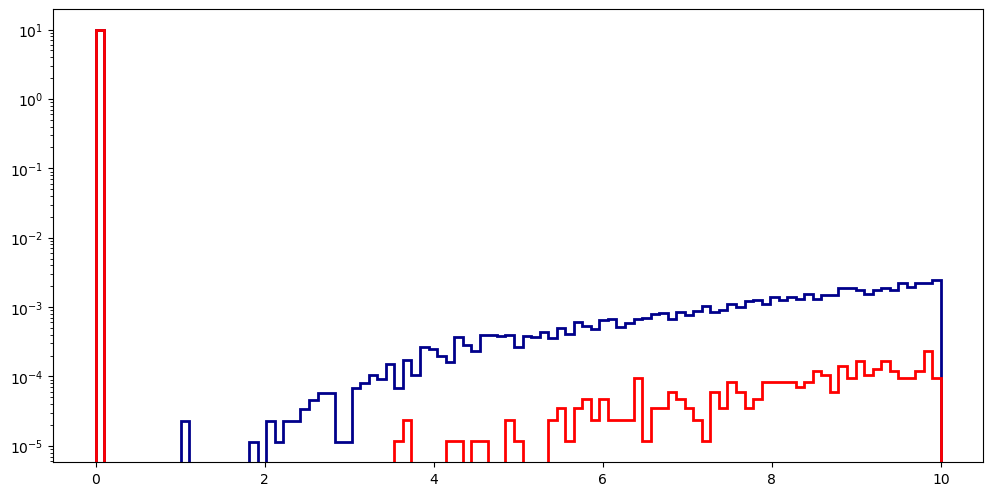

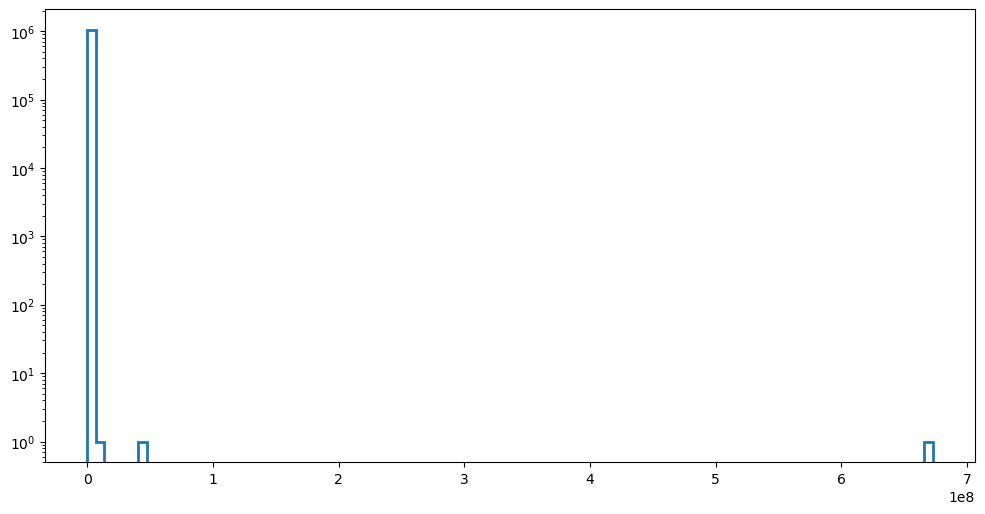

18.346920078288633
20.029954077405836


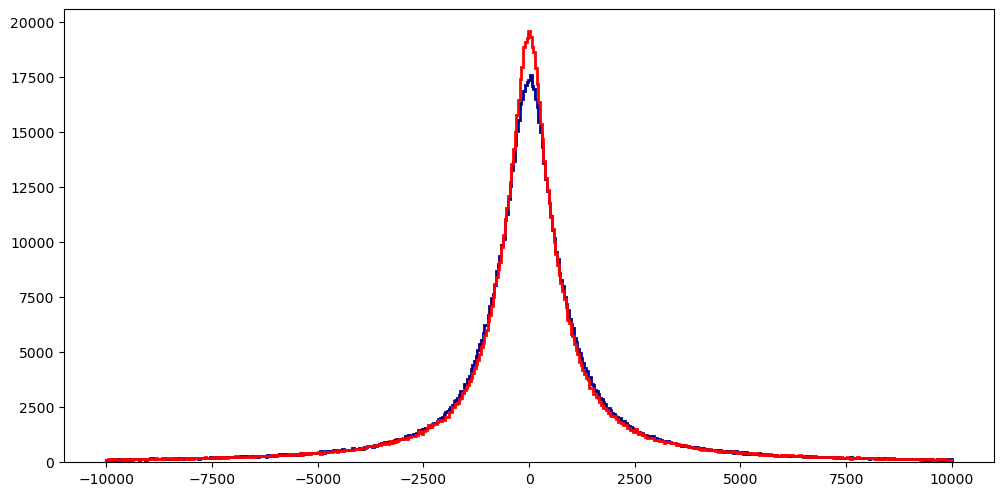

49.80594677097524
49.63234277684403


In [14]:
#For checkng ptcone, etacone
div1 = df['g1_ptcone']/df['g1_pt']
div2 = df['g2_ptcone']/df['g2_pt']
plt.figure(figsize=(12,6), dpi= 100)
xlims=[0,10]
bins = np.linspace(xlims[0],xlims[1],100,endpoint=True)
plt.yscale('log')
plt.hist(div1, color = 'darkblue', bins=bins, density = True, histtype='step', linewidth=2)
plt.hist(div2, color = 'red', bins=bins, density = True,histtype='step', linewidth=2)
plt.show()

plt.figure(figsize=(12,6), dpi= 100)
plt.hist(df['g1_ptcone'], bins = 100, histtype='step', linewidth=2)
plt.yscale('log')
plt.show()

#percent background using this cut
print(((len(div1[div1>0.05]))/(len(div1)))*100)
print(((len(div2[div2>0.05]))/(len(div2)))*100)

div1 = df['g1_etacone']/df['g1_eta']
div2 = df['g2_etacone']/df['g2_eta']
plt.figure(figsize=(12,6), dpi= 100)
xlims=[-10000,10000]
bins = np.linspace(xlims[0],xlims[1],500,endpoint=True)
plt.hist(div1, color = 'darkblue', bins=bins, histtype='step', linewidth=2)
plt.hist(div2, color = 'red', bins=bins, histtype='step', linewidth=2)
plt.show()

#percent background using this cut
print(((len(div1[div1>0.065]))/(len(div1)))*100)
print(((len(div2[div2>0.065]))/(len(div2)))*100)

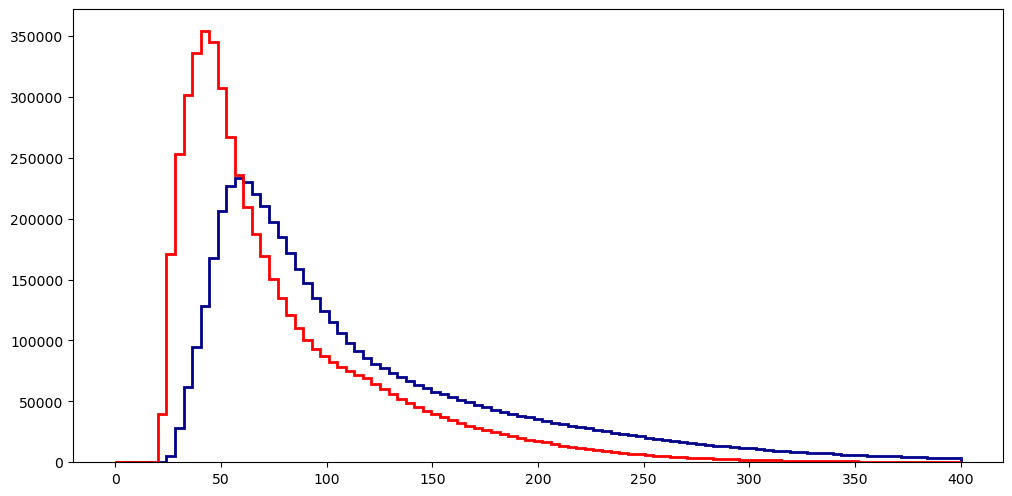

22.9192
22.002


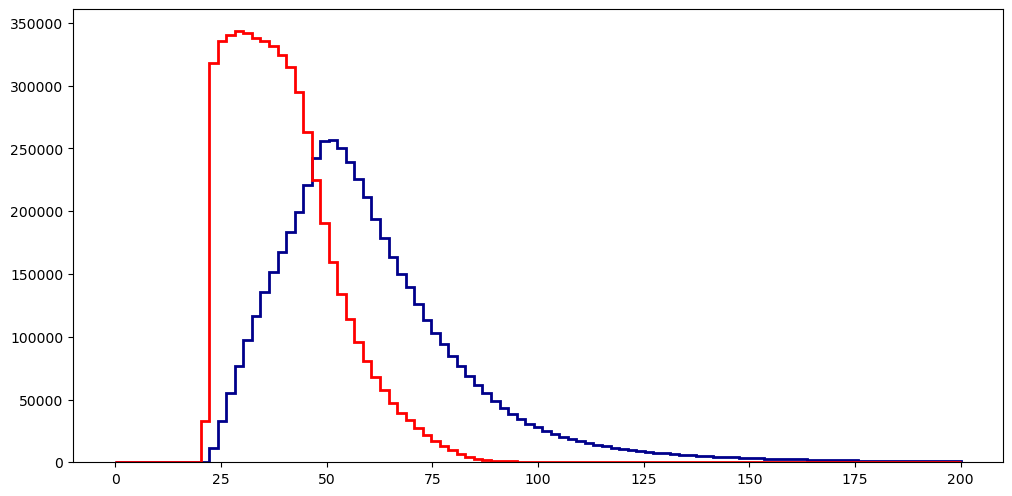

22.0329
22.0


In [24]:
#for checking energy values
en1 = df['g1_E'].values
en2 = df['g2_E'].values
plt.figure(figsize=(12,6), dpi= 100)
xlims=[0, 400]
bins = np.linspace(xlims[0],xlims[1],100,endpoint=True)
plt.hist(en1, color = 'darkblue', bins=bins, histtype='step', linewidth=2)
plt.hist(en2, color = 'red', bins=bins, histtype='step', linewidth=2)
plt.show()

print(min(en1))
print(min(en2))

pt1 = df['g1_pt'].values
pt2 = df['g2_pt'].values
plt.figure(figsize=(12,6), dpi= 100)
xlims=[0, 200]
bins = np.linspace(xlims[0],xlims[1],100,endpoint=True)
plt.hist(pt1, color = 'darkblue', bins=bins, histtype='step', linewidth=2)
plt.hist(pt2, color = 'red', bins=bins, histtype='step', linewidth=2)
plt.show()

print(min(pt1))
print(min(pt2))

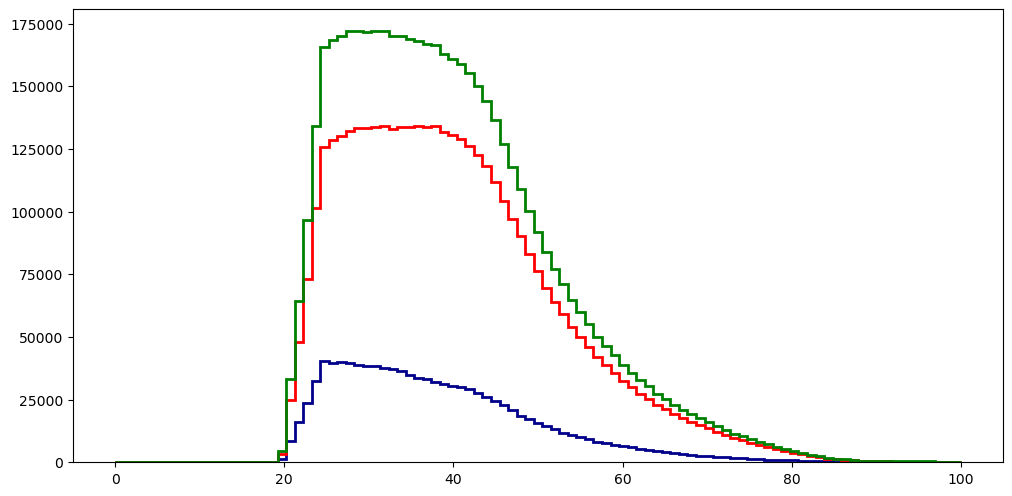

19.637347282359702
527.2833675210759


In [27]:
#Inspect the angle betwqeen photons
plt.figure(figsize=(12,6), dpi= 100)
del_r = df['photon_sep'].values
sigs = df['photon_sep'][df['label']==1].values
bkgs = df['photon_sep'][df['label']==0].values
xlims=[0, 100]
bins = np.linspace(xlims[0],xlims[1],100,endpoint=True)
plt.hist(bkgs, color = 'darkblue', histtype='step', bins=bins,linewidth=2)
plt.hist(sigs, color = 'red', histtype='step', bins=bins,linewidth=2)
plt.hist(del_r, color = 'green', histtype='step', bins=bins,linewidth=2)
plt.show()

print(min(del_r))
print(max(del_r))

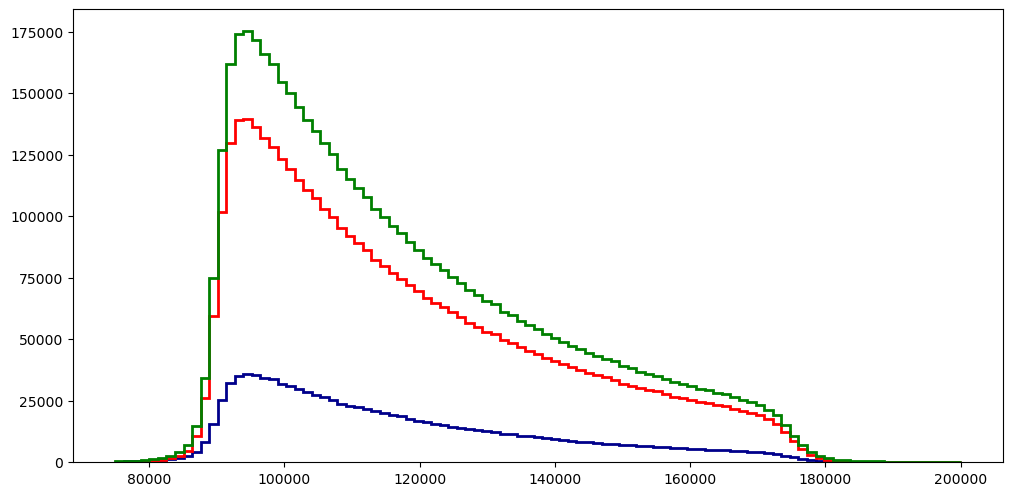

0.0244632
1928270.0


In [36]:
#Do a plot of the mass spectrum
plt.figure(figsize=(12,6), dpi= 100)
inv_m = df['mass'].values
sigs = df['mass'][df['label']==1].values
bkgs = df['mass'][df['label']==0].values
xlims=[75000,200000]
bins = np.linspace(xlims[0],xlims[1],100,endpoint=True)
#plt.xlim((100000,150000))
plt.hist(bkgs, color = 'darkblue', histtype='step', bins=bins,linewidth=2)
plt.hist(sigs, color = 'red', histtype='step', bins=bins,linewidth=2)
plt.hist(inv_m, color = 'green', histtype='step', bins=bins,linewidth=2)
plt.show()

print(min(inv_m))
print(max(inv_m))

In [29]:
with open('./CSVfiles/ggH_sf.data', 'rb') as f:
    df=pickle.load(f)
df

,0,1,2,3,4,5
0,28.4857,55922600.0,0.000000,1.005130,0.999523,1.005130
1,28.4857,55922600.0,0.351687,0.970159,0.997608,0.970159
2,28.4857,55922600.0,0.553627,0.988219,0.998555,0.988219
3,28.4857,55922600.0,0.619412,0.986910,1.000000,0.986910
4,28.4857,55922600.0,0.619412,1.004190,0.994923,1.004190
...,...,...,...,...,...,...
1054705,28.4857,55922600.0,1.251330,0.952824,1.000000,0.952824
1054706,28.4857,55922600.0,1.251330,0.990247,1.000000,0.990247
1054707,28.4857,55922600.0,1.214120,0.998569,1.000000,0.998569
1054708,28.4857,55922600.0,1.320950,0.992051,0.998649,0.992051


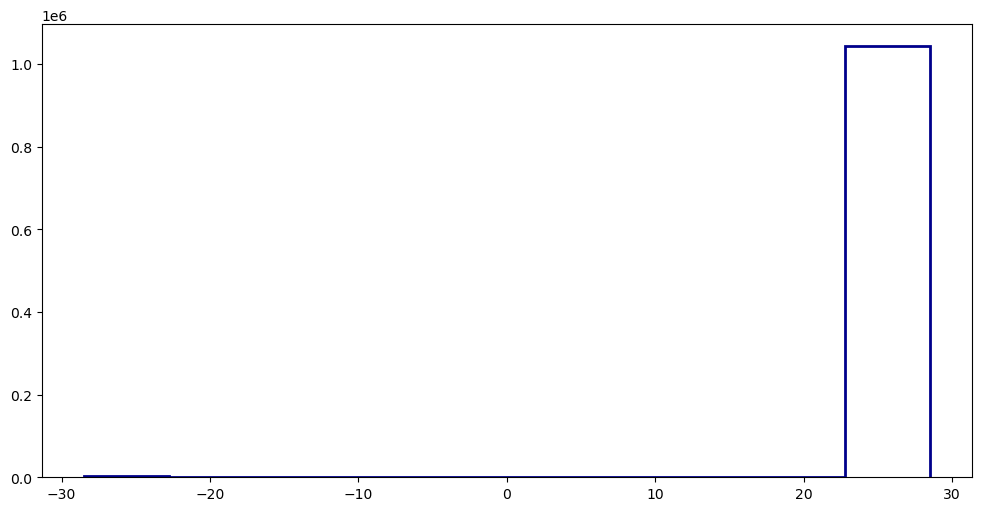

-28.4857
28.4857
2285


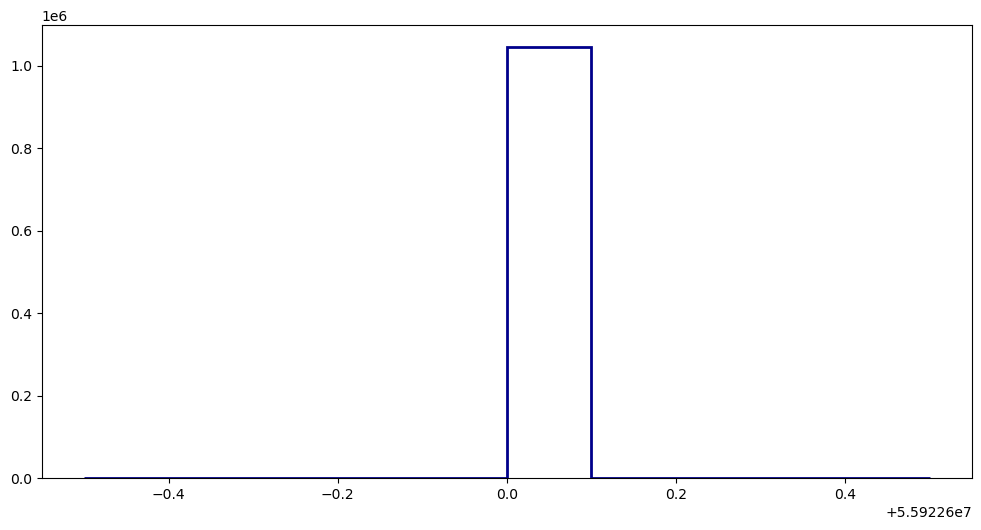

55922600.0
55922600.0


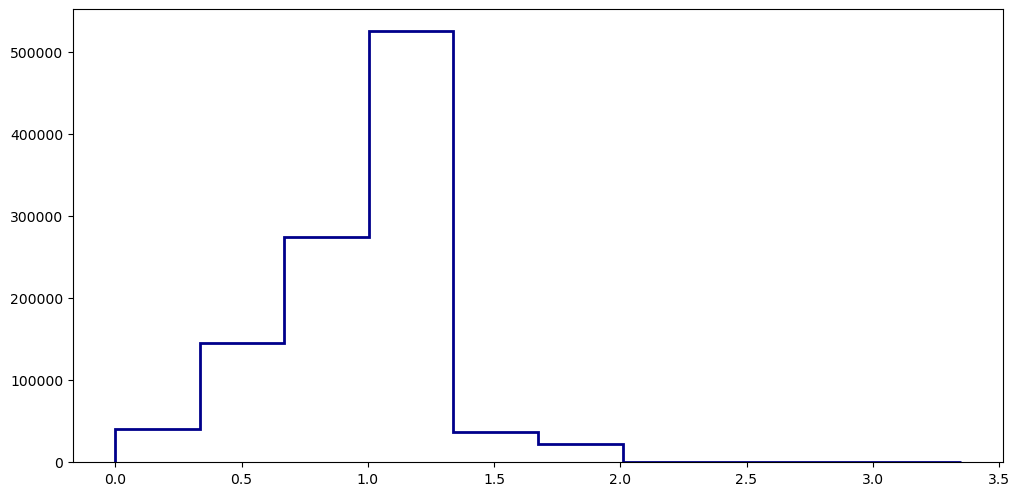

0.0
3.34815


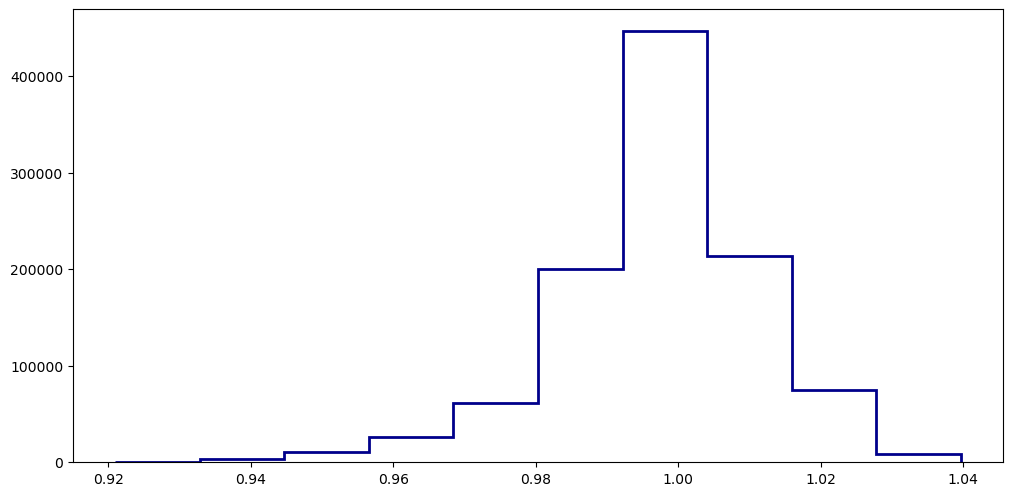

0.9209870000000001
1.0396299999999998


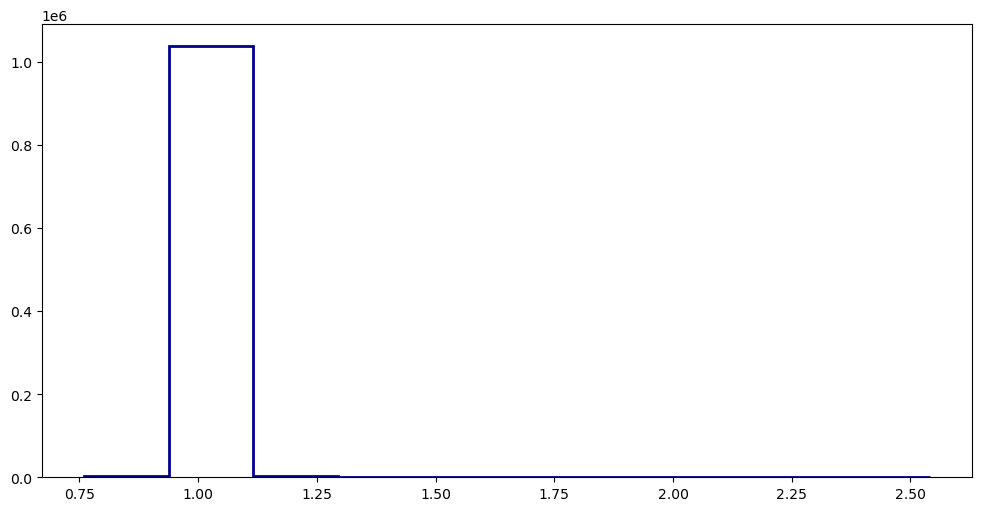

0.760089
2.54019


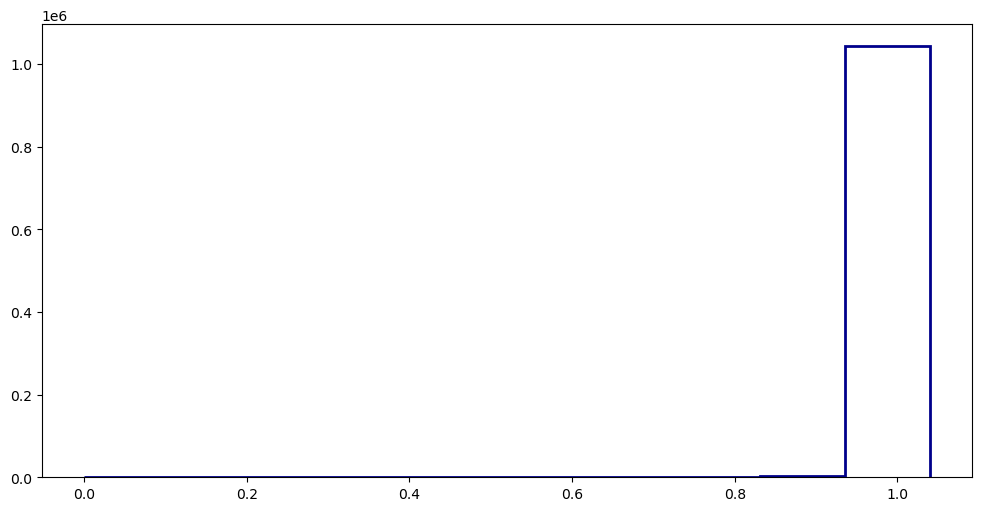

0.0
1.0396299999999998


In [8]:
#Look at scale factors 
mcWeight = df[0]
mcsum = df[1]
pileup = df[2]
photon = df[3]
btag = df[4]
phottrig = df[5]

plt.figure(figsize=(12,6), dpi= 100)
plt.hist(mcWeight, color = 'darkblue', histtype='step',linewidth=2)
plt.show()

print(min(mcWeight))
print(max(mcWeight))
print(len(mcWeight[mcWeight<28]))

plt.figure(figsize=(12,6), dpi= 100)
plt.hist(mcsum, color = 'darkblue', histtype='step',linewidth=2)
plt.show()

print(min(mcsum))
print(max(mcsum))

plt.figure(figsize=(12,6), dpi= 100)
plt.hist(pileup, color = 'darkblue', histtype='step',linewidth=2)
plt.show()

print(min(pileup))
print(max(pileup))

plt.figure(figsize=(12,6), dpi= 100)
plt.hist(photon, color = 'darkblue', histtype='step',linewidth=2)
plt.show()

print(min(photon))
print(max(photon))

plt.figure(figsize=(12,6), dpi= 100)
plt.hist(btag, color = 'darkblue', histtype='step',linewidth=2)
plt.show()

print(min(btag))
print(max(btag))

plt.figure(figsize=(12,6), dpi= 100)
plt.hist(phottrig, color = 'darkblue', histtype='step',linewidth=2)
plt.show()

print(min(phottrig))
print(max(phottrig))